## Import Libraries:

In [1]:
import warnings
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import os  # For interacting with the operating system
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.model_selection import ParameterGrid  # For generating parameter grid for hyperparameter tuning
from sklearn.metrics import log_loss  # For calculating log loss metric
from itertools import product  # For creating Cartesian products of iterables
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Suppress specific UserWarnings from the 'openpyxl' module to prevent cluttering the output
warnings.filterwarnings("ignore", category=UserWarning, module='openpyxl')

## Load the data:

In [2]:
# Define the directory where your files are located
# data_dir = '.'  
data_dir = os.path.join(os.path.pardir) 

# List to hold the dataframes
dataframes = []

# Loop through the years and load the files
for year in range(2005, 2020):
    if year <= 2012:
        file_path = os.path.join(data_dir, f'{year}.xls')
    else:
        file_path = os.path.join(data_dir, f'{year}.xlsx')

    # Load the file into a dataframe
    df = pd.read_excel(file_path)

    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes into one
betting_data = pd.concat(dataframes, ignore_index=True)

## Fixing Anomalies:

In [3]:
def is_column_numeric(df, column_name):
    # Check if the column contains only numeric values
    return df[column_name].apply(lambda x: str(x).isnumeric()).all()

In [4]:
# Check if columns are numeric before converting
anomaly_column = ['WRank', 'LRank', 'EXW']
for column in anomaly_column:
    if is_column_numeric(betting_data, column):
        print(f"Column '{column}' is numeric.\n")
    else:
        print(f"Column '{column}' is not numeric.\n")

Column 'WRank' is not numeric.

Column 'LRank' is not numeric.

Column 'EXW' is not numeric.



In [5]:
def find_non_numeric_values(df, column_name):
    # Function to check if a value is numeric
    def is_numeric(value):
        try:
            float(value)
            return True
        except ValueError:
            return False

    # Apply the function to the column and filter non-numeric values
    non_numeric_values = df[~df[column_name].apply(is_numeric)]

    # Display the non-numeric values
    print(f"Non-numeric values in {column_name}:")
    print(non_numeric_values[[column_name]], "\n")
    print()

In [6]:
# WRank column
find_non_numeric_values(betting_data, 'WRank')

Non-numeric values in WRank:
Empty DataFrame
Columns: [WRank]
Index: [] 




In [7]:
# LRank column
find_non_numeric_values(betting_data, 'LRank')

Non-numeric values in LRank:
Empty DataFrame
Columns: [LRank]
Index: [] 




In [8]:
# EXW column
find_non_numeric_values(betting_data, 'EXW')

Non-numeric values in EXW:
        EXW
23776  2.,3 




In [9]:
# Convert WRank and LRank to numeric, coercing errors
betting_data['WRank'] = pd.to_numeric(betting_data['WRank'], errors='coerce')
betting_data['LRank'] = pd.to_numeric(betting_data['LRank'], errors='coerce')

# Fill NaN values with a high number
betting_data['WRank'].fillna(100000, inplace=True)
betting_data['LRank'].fillna(100000, inplace=True)


# Correct the typo in row 38294, column 'EXW'
if betting_data.at[38294, 'EXW'] == '2.,3':
    betting_data.at[38294, 'EXW'] = '2.3'

## Preprocess Dataset:

In [10]:
# Calculate whether the higher-ranked player won the match (1 if higher-ranked player won, 0 otherwise)
betting_data['higher_rank_won'] = (betting_data['WRank'] < betting_data['LRank']).astype(int)

# Calculate points for the higher-ranked player based on the match outcome
betting_data['higher_rank_points'] = (
    betting_data['higher_rank_won'] * betting_data['WPts'] + 
    betting_data['LPts'] * (1 - betting_data['higher_rank_won'])
)

# Calculate points for the lower-ranked player based on the match outcome
betting_data['lower_rank_points'] = (
    (1 - betting_data['higher_rank_won']) * betting_data['WPts'] + 
    betting_data['LPts'] * betting_data['higher_rank_won']
)

# Fill any missing values in 'higher_rank_points' with 0 to ensure consistency
betting_data['higher_rank_points'].fillna(0, inplace=True)

# Fill any missing values in 'lower_rank_points' with 0 to ensure consistency
betting_data['lower_rank_points'].fillna(0, inplace=True)

# Filter the DataFrame to include only rows where the match status is 'Completed'
# This ensures that only fully played matches are considered in the analysis
betting_data = betting_data.loc[betting_data['Comment'] == 'Completed']

# Create a copy of the betting data for further analysis and processing
all_matches_538 = betting_data.copy()

# Define a list of columns to drop from the dataset to focus on essential features
columns_to_drop = [
    'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment',
    'CBW', 'CBL', 'IWW', 'IWL', 'B365W', 'B365L', 
    'EXW', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL',
    'MaxW', 'MaxL', 'AvgW', 'AvgL'
]

# Drop the unnecessary columns from the dataset to simplify analysis
all_matches_538 = all_matches_538.drop(columns=columns_to_drop)

## ELO Setup:

## Model Simulation:

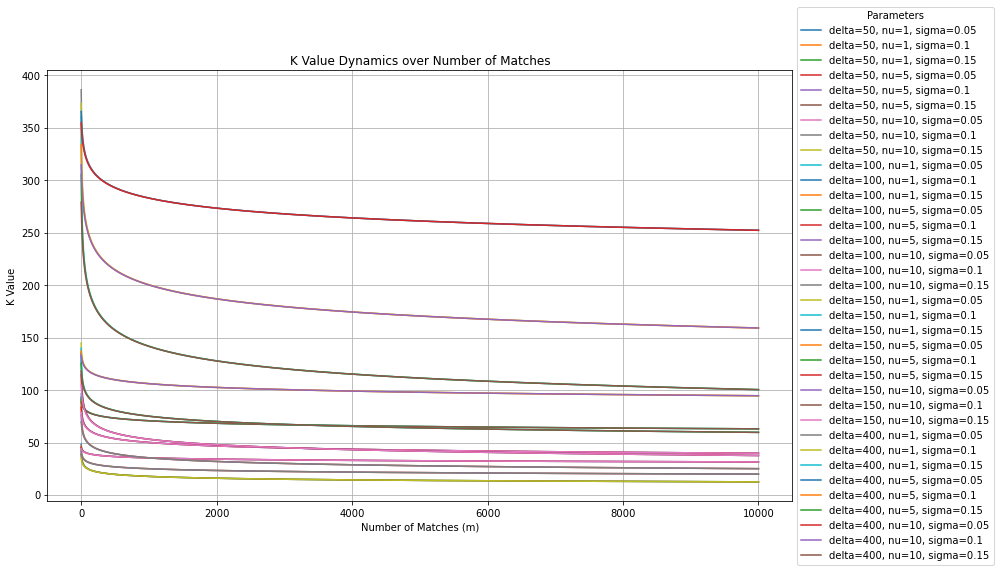

In [11]:
# Define the parameter grid for the FiveThirtyEight model
param_grid = {
    'delta': [50, 100, 150, 400],
    'nu': [1, 5, 10],
    'sigma': [0.05, 0.1, 0.15]
}

# Sequence of matches
m = np.arange(1, 10001)

# Initialize a DataFrame to store results
results = []

# Iterate over all parameter combinations
for delta, nu, sigma in product(param_grid['delta'], param_grid['nu'], param_grid['sigma']):
    # Calculate K values for FiveThirtyEight model
    K_FTE = delta / (m + nu) ** sigma

    # Store results in a DataFrame
    df = pd.DataFrame({
        'm': m,
        'K_FTE': K_FTE,
        'delta': delta,
        'nu': nu,
        'sigma': sigma
    })
    results.append(df)

# Concatenate all results into a single DataFrame
all_results = pd.concat(results)

# Plot the K values for different parameter combinations
plt.figure(figsize=(14, 8))
for (delta, nu, sigma), group in all_results.groupby(['delta', 'nu', 'sigma']):
    label = f'delta={delta}, nu={nu}, sigma={sigma}'
    plt.plot(group['m'], group['K_FTE'], label=label)

plt.xlabel('Number of Matches (m)')
plt.ylabel('K Value')
plt.title('K Value Dynamics over Number of Matches')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

## Grid Search Optimization for the 538 Elo Model:

## Function Definitions and Setup:

In [12]:
def win_probability(E_i, E_j):
    """
    Calculate the probability of Player i winning against Player j based on their ratings.

    Parameters:
    E_i (float): The rating of Player i.
    E_j (float): The rating of Player j.

    Returns:
    float: The probability of Player i winning.
    """
    # Calculate and return the win probability using the Elo rating formula
    return 1 / (1 + 10 ** ((E_j - E_i) / 400))

In [13]:
def get_player_elo(player_name):
    """
    Retrieve the Elo rating of a player. If the player is not in the Elo dictionary,
    assign them an initial Elo rating.

    Parameters:
    player_name (str): The name of the player.

    Returns:
    float: The Elo rating of the player.
    """
    # Check if the player is in the dictionary of Elo ratings
    if player_name not in players_elo:
        # If the player is not found, assign them the initial Elo rating
        players_elo[player_name] = initial_elo
        
    # Return the player's Elo rating    
    return players_elo[player_name]

In [14]:
def set_player_elo(player_name, elo):
    """
    Set the Elo rating for a specific player.

    Parameters:
    player_name (str): The name of the player.
    elo (float): The new Elo rating to be assigned to the player.
    """
    # Assign the given Elo rating to the specified player in the players_elo dictionary
    players_elo[player_name] = elo

In [15]:
def get_games_played(player_name):
    """
    Retrieve the number of games played by a player. If the player is not in the dictionary,
    initialize their games played count to 0.

    Parameters:
    player_name (str): The name of the player.

    Returns:
    int: The number of games the player has played.
    """
    # Check if the player is in the dictionary tracking games played
    if player_name not in players_games_played:
        # If the player is not found, initialize their games played count to 0
        players_games_played[player_name] = 0
    
    # Return the number of games the player has played
    return players_games_played[player_name]

In [16]:
def increment_games_played(player_name):
    """
    Increment the number of games played by a player by 1. If the player is not in the
    dictionary, initialize their games played count to 1.

    Parameters:
    player_name (str): The name of the player whose games played count is to be incremented.

    Returns:
    None: The function updates the dictionary in place.
    """
    # Increment the games played count for the player by 1.
    # If the player is not in the dictionary, initialize their count to 1.
    players_games_played[player_name] = players_games_played.get(player_name, 0) + 1


In [17]:
def update_elo_538(E_i, E_j, outcome, games_played_i):
    """
    Update the Elo rating for a player using the 538 method, which adjusts the K-factor
    based on the number of games the player has played.

    Parameters:
    E_i (float): The current Elo rating of player i.
    E_j (float): The Elo rating of the opponent, player j.
    outcome (str): The outcome of the match for player i. Should be 'win' or 'loss'.
    games_played_i (int): The number of games player i has played.

    Returns:
    float: The updated Elo rating of player i.
    """
    # Calculate the K-factor based on the number of games player i has played.
    K = 100 / (games_played_i + 10) ** 0.15
    
    # Calculate the win probability for player i against player j.
    pi_j = win_probability(E_i, E_j)
    
    if outcome == 'win':
        # Calculate Elo rating change for a win.
        delta_E_i = K * (1 - pi_j)
        new_E_i = E_i + delta_E_i
    
    elif outcome == 'loss':
        # Calculate Elo rating change for a loss.
        delta_E_i = K * (pi_j - 1)
        new_E_i = E_j + delta_E_i
    
    else:
        # Raise an error if the outcome is neither 'win' nor 'loss'.
        raise ValueError("Outcome must be 'win' or 'loss'")
    
    # Return the updated Elo rating for player i.
    return new_E_i

In [18]:
def evaluate_model(df):
    """
    Evaluate the performance of a model by calculating log loss, accuracy, and calibration.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the actual outcomes and predicted probabilities.
                           Expected columns:
                           - 'higher_rank_won': Actual outcome (1 if higher-ranked player won, 0 otherwise).
                           - 'prob_high_ranked': Predicted probability of the higher-ranked player winning.
                           - 'match_outcome': Actual match outcome (can be used to calculate accuracy).

    Returns:
    tuple: A tuple containing:
           - logloss_value (float): The log loss of the predictions.
           - accuracy_value (float): The accuracy of the model.
           - calibration_value (float): The calibration metric for the predictions.
    """
    # Calculate log loss between the actual outcomes and predicted probabilities
    logloss_value = log_loss(df.higher_rank_won, df.prob_high_ranked)
    
    # Calculate accuracy by comparing predicted match outcome with the actual outcome
    accuracy_value = np.mean(df.match_outcome == df.higher_rank_won)
    
    # Calculate calibration by dividing the sum of predicted probabilities by the sum of actual outcomes
    calibration_value = np.sum(df.prob_high_ranked) / np.sum(df.higher_rank_won)
    
    # Return the calculated metrics
    return accuracy_value, calibration_value, logloss_value

In [19]:
# Initialize an empty list to store results
results = []

def update_elo_538_param(E_i, E_j, outcome, games_played_i, delta, nu, sigma):
    """
    Update the Elo rating for a player using a parameterized version of the 538 method,
    allowing for flexible adjustment of the K-factor calculation.

    Parameters:
    E_i (float): The current Elo rating of player i.
    E_j (float): The Elo rating of the opponent, player j.
    outcome (str): The outcome of the match for player i. Should be 'win' or 'loss'.
    games_played_i (int): The number of games player i has played.
    delta (float): A parameter that controls the base K-factor.
    nu (float): A parameter that adjusts the games played factor in the K-factor formula.
    sigma (float): A parameter that controls the scaling of the games played factor in the K-factor formula.

    Returns:
    float: The updated Elo rating of player i.
    """
    # Calculate the K-factor using the provided delta, nu, and sigma parameters
    K = delta / (games_played_i + nu) ** sigma
    
    # Calculate the win probability for player i against player j
    pi_j = win_probability(E_i, E_j)
    
    if outcome == 'win':
        # Calculate Elo rating change for a win
        delta_E_i = K * (1 - pi_j)
        new_E_i = E_i + delta_E_i
    
    elif outcome == 'loss':
        # Calculate Elo rating change for a loss
        delta_E_i = K * (pi_j - 1)
        new_E_i = E_j + delta_E_i
    
    else:
        # Raise an error if the outcome is neither 'win' nor 'loss'
        raise ValueError("Outcome must be 'win' or 'loss'")
    
    # Return the updated Elo rating for player i
    return new_E_i

In [20]:
def update_elo_and_probabilities_538_param(df, delta, nu, sigma):
    """
    Update the Elo ratings and win probabilities for each match in the dataset using
    a parameterized version of the 538 method.

    Parameters:
    df (pandas.DataFrame): DataFrame containing match data. Expected columns:
                           - 'Winner': Name of the player who won the match.
                           - 'Loser': Name of the player who lost the match.
                           - 'higher_rank_won': Boolean indicating if the higher-ranked player won.
    delta (float): A parameter that controls the base K-factor.
    nu (float): A parameter that adjusts the games played factor in the K-factor formula.
    sigma (float): A parameter that controls the scaling of the games played factor in the K-factor formula.

    Returns:
    None: The DataFrame is modified in place with updated Elo ratings and probabilities.
    """
    for index, match in df.iterrows():
        winner_name, loser_name = match['Winner'], match['Loser']

        # Retrieve current Elo ratings for both players
        winner_elo = get_player_elo(winner_name)
        loser_elo = get_player_elo(loser_name)

        # Store initial Elo ratings in the DataFrame
        df.at[index, 'winner_initial_elo'] = winner_elo
        df.at[index, 'loser_initial_elo'] = loser_elo

        # Get the number of games played by each player
        games_played_winner = get_games_played(winner_name)
        games_played_loser = get_games_played(loser_name)

        # Calculate the win probability of the winner against the loser
        df.at[index, 'prob_winner'] = win_probability(winner_elo, loser_elo)

        # Determine and record the match outcome and probabilities
        if match['higher_rank_won']:
            # If the higher-ranked player won, record if they were expected to win
            df.at[index, 'match_outcome'] = int(df.at[index, 'prob_winner'] > 0.5)
            df.at[index, 'prob_high_ranked'] = df.at[index, 'prob_winner']
        else:
            # If the lower-ranked player won, record the probability of their victory
            df.at[index, 'match_outcome'] = int((1 - df.at[index, 'prob_winner']) > 0.5)
            df.at[index, 'prob_high_ranked'] = 1 - df.at[index, 'prob_winner']

        # Update Elo ratings for both players
        new_winner_elo = update_elo_538_param(winner_elo, loser_elo, 'win', games_played_winner, delta, nu, sigma)
        new_loser_elo = update_elo_538_param(winner_elo, loser_elo, 'loss', games_played_loser, delta, nu, sigma)
        set_player_elo(winner_name, new_winner_elo)
        set_player_elo(loser_name, new_loser_elo)

        # Store new Elo ratings in the DataFrame
        df.at[index, 'winner_new_elo'] = new_winner_elo
        df.at[index, 'loser_new_elo'] = new_loser_elo

        # Increment the number of games played by both players
        increment_games_played(winner_name)
        increment_games_played(loser_name)

## Implementation of Grid Search for Parameter Tuning:

In [21]:
# ELO Setup
initial_elo = 1500
players_elo = {}

In [22]:
# Initialize a dictionary to track the number of games played by each player
players_games_played = {}

In [23]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'delta': list(range(10, 150, 5)),  # 'delta' parameter: Values from 10 to 145 with a step of 5
    'nu': list(range(10, 50, 5)),      # 'nu' parameter: Values from 10 to 45 with a step of 5
    'sigma': [x / 100 for x in range(15, 55, 5)]  # 'sigma' parameter: Values from 0.15 to 0.50 with a step of 0.05
}

In [ ]:
# Iterate over each combination of parameters in the parameter grid
for params in ParameterGrid(param_grid):
    # Initialize Elo ratings and games played dictionaries for each set of parameters
    players_elo = {}
    players_games_played = {}
    
    # Create a copy of the matches dataset to avoid modifying the original dataset
    all_matches_538_elo = all_matches_538.copy()
    
    # Update Elo ratings and probabilities for each match using the current set of parameters
    update_elo_and_probabilities_538_param(all_matches_538_elo, params['delta'], params['nu'], params['sigma'])
    
    # Convert the 'Date' column to datetime format for splitting the dataset
    all_matches_538_elo['Date'] = pd.to_datetime(all_matches_538_elo['Date'], format='%Y-%m-%d')
    
    # Define the split date for training and validation datasets (January 1, 2019)
    split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
    
    # Split the dataset into training and validation sets based on the defined split time
    all_matches_538_elo_train = all_matches_538_elo[all_matches_538_elo['Date'] < split_time]
    all_matches_538_elo_validation = all_matches_538_elo[all_matches_538_elo['Date'] >= split_time]
    
    # Evaluate the model using the validation set and calculate log loss, accuracy, and calibration
    accuracy_value, calibration_value, logloss_value = evaluate_model(all_matches_538_elo_validation)
    
    # Append the results for the current set of parameters to the results list
    results.append({
        'delta': params['delta'],
        'nu': params['nu'],
        'sigma': params['sigma'],
        'logloss': logloss_value,
        'accuracy': accuracy_value,
        'calibration': calibration_value
    })

# Convert the results list into a DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Find the best parameters based on the minimum log loss
best_params_logloss = results_df.loc[results_df['logloss'].idxmin()]

# Find the best parameters based on the maximum accuracy
best_params_accuracy = results_df.loc[results_df['accuracy'].idxmax()]

# Print the best parameters based on log-loss
print(f"Best parameters based on log-loss: \n{best_params_logloss}\n")

# Print the best parameters based on accuracy
print(f"Best parameters based on accuracy: \n{best_params_accuracy}\n")

## Optimization and Identification of Optimal Parameter Values:

In [ ]:
# Filter rows where accuracy is greater than 0.64
filtered_df_accuracy = results_df[results_df['accuracy'] > 0.641]

# Sort the filtered DataFrame by ascending order of log-loss
sorted_df_accuracy = filtered_df_accuracy.sort_values(by='logloss')

sorted_df_accuracy.head()

In [ ]:
# Filter rows where logloss is less than 0.633985 and accuracy is greater than 0.63
filtered_df_logloss = results_df[(results_df['logloss'] < 0.633985) & (results_df['accuracy'] > 0.63)]

# Sort the filtered DataFrame by ascending order of logloss
sorted_df_logloss = filtered_df_logloss.sort_values(by='logloss')

sorted_df_logloss.head()

In [ ]:
# Get the first row of each dataframe
optimisation_1 = sorted_df_logloss.iloc[0]
optimisation_2 = sorted_df_accuracy.iloc[0]
optimisation_3 = sorted_df_accuracy.iloc[1]
optimisation_4 = sorted_df_accuracy.iloc[16]

# Combine the rows into a single dataframe for comparison
comparison_df = pd.DataFrame({
    'Optimisation 1': optimisation_1,
    'Optimisation 2': optimisation_2,
    'Optimisation 3': optimisation_3,
    'Optimisation 4': optimisation_4
}).T

comparison_df

## 3D Visualization of Log Loss Across Delta, Nu, and Sigma Parameters:

In [ ]:
# Prepare data for 3D plot
X = results_df['delta']
Y = results_df['nu']
Z = results_df['sigma']
log_loss_values = results_df['logloss']

# Create a figure and 3D axis for the plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Create 3D scatter plot with better visualization
sc = ax.scatter(X, Y, Z, c=log_loss_values, cmap='viridis', marker='o', s=60, alpha=0.8, edgecolor='k')

# Find the minimum log loss and its corresponding parameters
min_loss_index = np.argmin(log_loss_values)
min_X = X.iloc[min_loss_index]
min_Y = Y.iloc[min_loss_index]
min_Z = Z.iloc[min_loss_index]
min_loss = log_loss_values.iloc[min_loss_index]

# Highlight the minimum log loss point with a larger red marker
ax.scatter(min_X, min_Y, min_Z, color='red', s=150, edgecolor='black', label='Minimum Log Loss', marker='^')

# Add a color bar which maps log loss values to colors
cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label('Log Loss', fontsize=12)

# Set labels and title with improved readability
ax.set_xlabel('Delta', fontsize=12, labelpad=10)
ax.set_ylabel('Nu', fontsize=12, labelpad=10)
ax.set_zlabel('Sigma', fontsize=12, labelpad=10)
ax.set_title('3D Visualization of Log Loss Across Delta, Nu, and Sigma Parameters', fontsize=14, pad=20)

# Show legend with a better location
ax.legend(loc='best', fontsize=10)

# Add annotation below the plot
plt.figtext(0.13, 0.03, f'Minimum Log Loss: {min_loss:.4f} at (Delta: {min_X}, Nu: {min_Y}, Sigma: {min_Z})', fontsize=12, ha='left')

# Show the plot
plt.show()

## Implementation of best parameters

In [ ]:
# Update Elo ratings based on the selected best parameters
players_elo = {}
players_games_played = {}
update_elo_and_probabilities_538_param(all_matches_538, 120, 25, 0.35)

## Split Dataset:

In [ ]:
all_matches_538['Date'] = pd.to_datetime(all_matches_538['Date'], format='%Y-%m-%d')
split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
all_matches_538_train = all_matches_538[all_matches_538['Date'] < split_time]
all_matches_538_validation = all_matches_538[all_matches_538['Date'] >= split_time]

## Evaluate Model Performance:

In [ ]:
print("\033[1mMetrics - Optimised ELO 538\033[0m")
accuracy_538, calibration_538, log_loss_538 = evaluate_model(all_matches_538_validation)

In [ ]:
# Create a DataFrame with the selected metrics
metric_comparison = pd.DataFrame({
    'Model': ['K_Constant', 'FiveThirtyEight_(538)', "538_Optimised"],
    'Accuracy': [0.629772, 0.635943, accuracy_538],
    'Log_Loss': [0.633985, 0.650521, log_loss_538],
    'Calibration': [1.028118, 1.064329, calibration_538]
})

# Print the DataFrame
metric_comparison

## Filtering Top 50 and Top 100 Ranking players from the dataset:

In [ ]:
# Load your dataset
df = all_matches_538_validation

In [ ]:
# Define function to filter dataset for top N players
def filter_top_players(df, top_n):
    df_top = df[(df['WRank'] <= top_n) | (df['LRank'] <= top_n)]
    return df_top

In [ ]:
# Filter the dataset for top 50 and top 100 players
df_top_50 = filter_top_players(df, 50)
df_top_100 = filter_top_players(df, 100)

## Metrics - Top 50 & Top 100:

In [ ]:
print("\033[1mMetrics - Top 50\033[0m")
accuracy_50, calibration_50, log_loss_50 = evaluate_model(df_top_50)

In [ ]:
print("\033[1mMetrics - Top 100\033[0m")
accuracy_100, calibration_100, log_loss_100 = evaluate_model(df_top_100)

In [ ]:
# Create a DataFrame to store the validation statistics
validation_stats = pd.DataFrame({
    'Model': [
        '538_Optimised', '538_Optimised Top 50', '538_Optimised Top 100'
    ],
    'Accuracy': [
        accuracy_538, accuracy_50, accuracy_100
    ],
    'Log_Loss': [
        log_loss_538, log_loss_50, log_loss_100
    ],
    'Calibration': [
        calibration_538, calibration_50, calibration_100
    ]
})

# Print the validation statistics DataFrame
validation_stats